## Brief Introduction
In this notebook, I experimennt the visualization of Ranking Metrics for the Anomaly Detection Model after PCA. The problem is set up as "Unsupervised Anomaly Detection". I split the dataset into the Validation and Testing Dataset. 

The anomaly in the datast is a figure with mustache.

Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [1]:
from processing_functions_yale_faces import * # local to this notebook

import os
os.chdir('../')

from support_functions import *
from PCA_Functions import *

Using TensorFlow backend.


## Parameters

In [2]:
# Define the number of Principal Components to keep from the image
n_components  = 50
# Define the k for the Precision-K Metric
k = 10

## Import Dataset

In [3]:
# Define the images to be read and the corresponding labels
data_path = "Yale_Faces_Data/CroppedYale/"

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_yale_faces_data(data_path)

## Apply PCA

In [4]:
# Split the images and labels
imgs_train,imgs_test,labels_train,labels_test = split_data_labels_training_testing(imgs,labels)

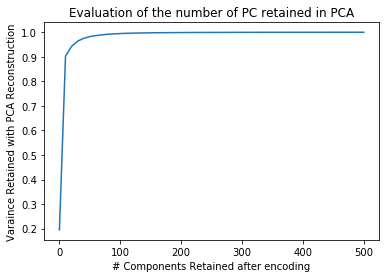

Below is the eigenfaces from the PCA Matrix


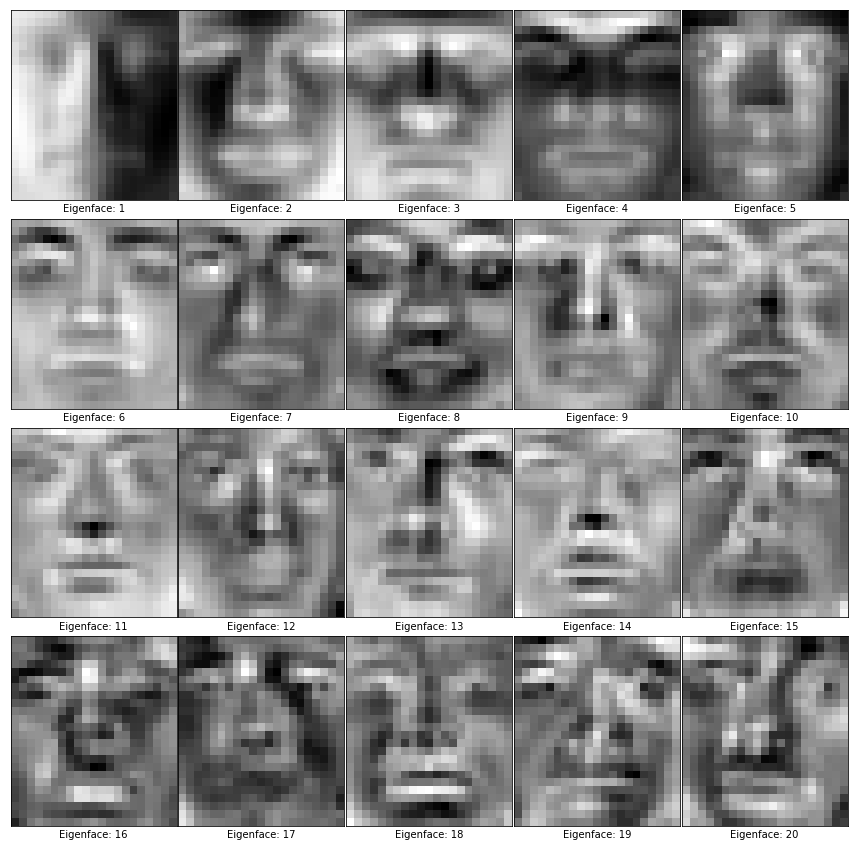


Below is a comparison between the original and the reconstructed data


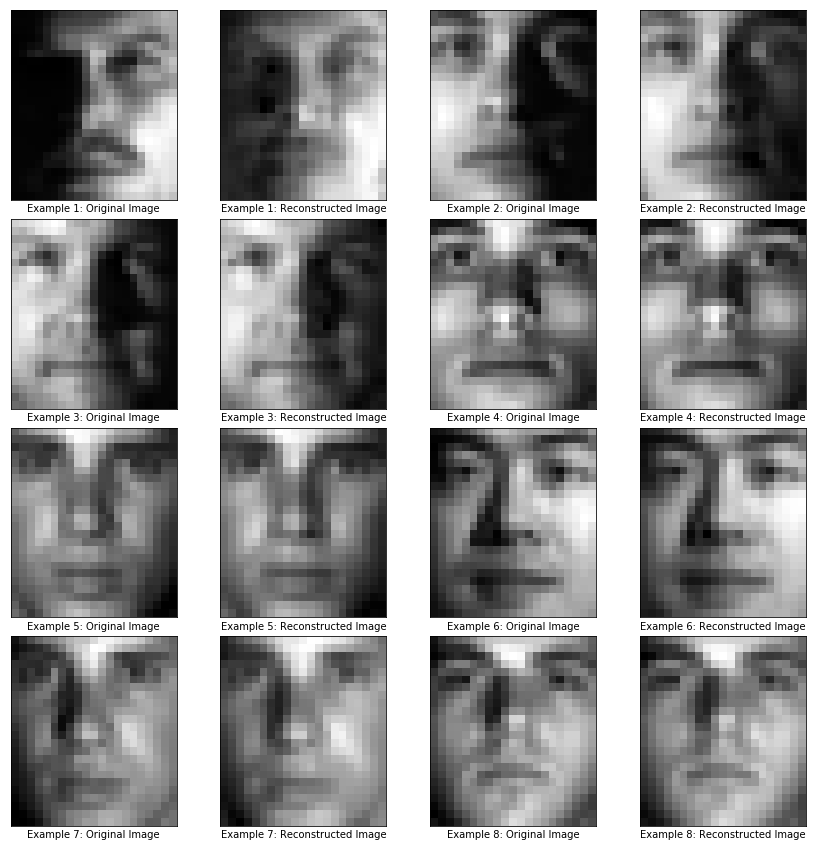


Summary of PCA Encoding: 
Number of Dimension in the Original Dataset: 504
Number of Dimension in the PCA-Encoded Dataset: 50
98.2% variance is retained with the current PCA Reconstruction.

Below is a scatter plot that ranks the data points according to their Reconstruction Errors.
The higher the reconstruction error, the more likely the point will be detected as an anomaly
The Black Points are True Anomalies, while the others are True Normal points


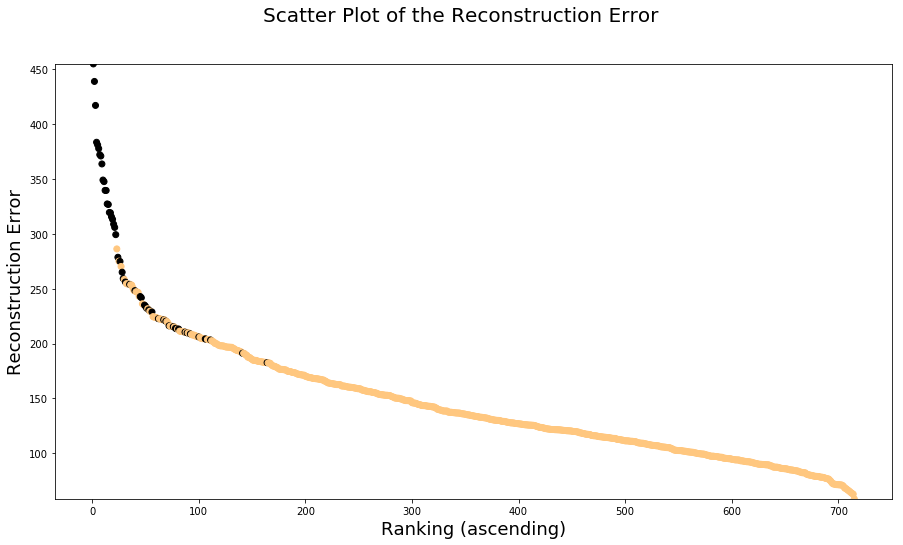


Training Results:
Precision: 64.3%
Recall: 67.9%
F-score: 66.1%
R-Precision (# R = 53): 66.0%
Precision@10: 100.0%


Testing Results:
Precision: 33.3%
Recall: 90.9%
F-score: 48.8%
R-Precision (# R = 11): 72.7%
Precision@10: 70.0%



In [5]:
# Anomaly Detection with Reconstruction Error
detection_with_pca_reconstruction_error(imgs_train,imgs_test,labels_train,labels_test,n_components,k,to_print=True,height=height,width=width)